## # Create a new folder NASA_DATA

In [0]:
# Create a new folder in DBFS
dbutils.fs.mkdirs("/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA")

True

## # Install Required libraries
- boto3, botocore : AWS
- netCDF4, h5netcdf: Reading netCDF files
- xarray: Designed to work with  multi-dimensional labeled datasets, extensions of NumPy arrays


In [0]:
!pip install boto3 botocore
!pip install netCDF4 h5netcdf
!pip install xarray
#!pip install dask


[notice] A new release of pip available: 22.2.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 29.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Not uninstalling packaging at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/

## #  Download file from NASA NEX-GDDP from AWS S3


In [0]:
import boto3, botocore, os

# S3 client with unsigned access
s3 = boto3.client(
    "s3",
    config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)

bucket = "nasanex"

# Parameters
scenario = "rcp85"          # or "historical", "rcp45"
variable = "tasmax"         # "tasmax", "tasmin", "pr" (precipitation)
model = "inmcm4"            # example model
years_to_download = [2020]  # example years

# Correct prefix
prefix = f"NEX-GDDP/BCSD/{scenario}/day/atmos/{variable}/r1i1p1/v1.0/"

print(f"Checking S3 path: s3://{bucket}/{prefix}")

response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

if "Contents" not in response:
    print("No files found at this prefix!")
else:
    i=0
    for obj in response["Contents"]:
        key = obj["Key"]
        if any(str(year) in key for year in years_to_download) and key.endswith(".nc"):
            tmp_path = f"/tmp/{os.path.basename(key)}"
            dbfs_path = f"dbfs:/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/{os.path.basename(key)}"
            
            # Download from S3 to local temp
            s3.download_file(bucket, key, tmp_path)
            
            # Copy to DBFS (correct path)
            dbutils.fs.cp(f"file:{tmp_path}", dbfs_path)
            
            # Clean up temp file
            os.remove(tmp_path)
            
            print(f"Copied {key} → {dbfs_path}")
print("Done!")

Checking S3 path: s3://nasanex/NEX-GDDP/BCSD/rcp85/day/atmos/tasmax/r1i1p1/v1.0/
Copied NEX-GDDP/BCSD/rcp85/day/atmos/tasmax/r1i1p1/v1.0/tasmax_day_BCSD_rcp85_r1i1p1_ACCESS1-0_2020.nc → dbfs:/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_day_BCSD_rcp85_r1i1p1_ACCESS1-0_2020.nc
Copied NEX-GDDP/BCSD/rcp85/day/atmos/tasmax/r1i1p1/v1.0/tasmax_day_BCSD_rcp85_r1i1p1_BNU-ESM_2020.nc → dbfs:/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_day_BCSD_rcp85_r1i1p1_BNU-ESM_2020.nc
Copied NEX-GDDP/BCSD/rcp85/day/atmos/tasmax/r1i1p1/v1.0/tasmax_day_BCSD_rcp85_r1i1p1_CCSM4_2020.nc → dbfs:/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_day_BCSD_rcp85_r1i1p1_CCSM4_2020.nc
Copied NEX-GDDP/BCSD/rcp85/day/atmos/tasmax/r1i1p1/v1.0/tasmax_day_BCSD_rcp85_r1i1p1_CESM1-BGC_2020.nc → dbfs:/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA

## # Calculate the size of the downloaded folder

In [0]:
folder_path = "/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA"
files = dbutils.fs.ls(folder_path)
total_size_bytes = sum(f.size for f in files if not f.isDir())
total_size_gb = total_size_bytes / (1024 ** 3)
print(f"Total size of {folder_path}: {total_size_gb:.4f} GB")

Total size of /FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA: 4.4405 GB


## # Read tasmax_day_BCSD_rcp85_r1i1p1_ACCESS1-0_2020.nc using netCDF4 library

In [0]:
from netCDF4 import Dataset

nc_path = "/dbfs/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_day_BCSD_rcp85_r1i1p1_ACCESS1-0_2020.nc"
ds = Dataset(nc_path, mode="r")

print("Variables (columns) in data:")
print(list(ds.variables.keys()))

Variables (columns) in data:
['time', 'tasmax', 'lat', 'lon']


This code block demonstrates how to read a NetCDF climate data file, extract a manageable subset, and convert it into a Spark DataFrame for scalable analysis in Databricks. The steps include:

- Initializing a Spark session.
- pecifying the path to the NetCDF file stored in DBFS.
- Opening the NetCDF file using the xarray library.
- Selecting a small subset of the data (first 30 time steps,  50 latitude, and 50 longitude points).
- Flattening the subset into a pandas DataFrame.
- Converting the pandas DataFrame to a Spark DataFrame.
- Writing the Spark DataFrame to Parquet format, partitioned by time for efficient querying.
- Displaying a sample of the Parquet data to verify the output.

This workflow enables efficient processing and analysis of large climate datasets using Spark and Databricks.

In [0]:
import xarray as xr
from pyspark.sql import SparkSession

# 1️⃣ Initialize Spark
spark = SparkSession.builder.getOrCreate()

# 2️⃣ Path to your NetCDF file in DBFS
nc_path = "/dbfs/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_day_BCSD_rcp85_r1i1p1_ACCESS1-0_2020.nc"

# 3️⃣ Open dataset (no chunking needed for small subset)
ds = xr.open_dataset(nc_path)

# 4️⃣ Select a small subset
#    - First 1000 time steps
#    - First 1000 lat points
#    - First 1000 lon points
ds_subset = ds.isel(time=slice(0,1000), lat=slice(0,1000), lon=slice(0,1000))

# 5️⃣ Flatten to pandas DataFrame (xarray automatically includes time, lat, lon)
pdf = ds_subset[["tasmax"]].to_dataframe().reset_index()

# 6️⃣ Convert to Spark DataFrame
df = spark.createDataFrame(pdf)

# 7️⃣ Write to Parquet (partitioned by time for fast queries)
parquet_path = "/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_subset_parquet"

df.write.mode("overwrite").partitionBy("time").parquet(parquet_path)

# 8️⃣ Verify a few rows
display(spark.read.parquet(parquet_path).limit(5))

print(f"✅ Subset Parquet written successfully to: {parquet_path}")


lat,lon,tasmax,time
-89.875,0.125,263.3824,2020-10-23T12:00:00.000+0000
-89.875,0.375,263.32678,2020-10-23T12:00:00.000+0000
-89.875,0.625,263.29294,2020-10-23T12:00:00.000+0000
-89.875,0.875,263.22888,2020-10-23T12:00:00.000+0000
-89.875,1.125,263.18655,2020-10-23T12:00:00.000+0000


✅ Subset Parquet written successfully to: /FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_subset_parquet


## #  Total Number of Rows

In [0]:
parquet_path = "/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_subset_parquet"
row_count = spark.read.parquet(parquet_path).count()
print(f"Number of rows in Parquet: {row_count}")

Number of rows in Parquet: 263520000


## Pre-processing steps :
- Tasmax is converted from Kelvin to Celcius and null values if any are removed.
- Three new colums _'year','month' and 'day'_ are created from column _'time'_

- A user-defined function (UDF) called `latlon_to_continent` that takes latitude and longitude as input and returns the name of the continent corresponding to those coordinates.

- A new cleaned parquet file is created.

## # create user defined function(UDF) latlon_to_continent 

In [0]:
def latlon_to_continent(lat, lon):
    if lat is None or lon is None:
        return "Unknown"
    if -10 <= lat <= 70 and -20 <= lon <= 50:
        return "Europe"
    elif -35 <= lat <= 37 and -20 <= lon <= 55:
        return "Africa"
    elif 5 <= lat <= 50 and 60 <= lon <= 150:
        return "Asia"
    elif -50 <= lat <= -10 and 110 <= lon <= 180:
        return "Oceania"
    elif 15 <= lat <= 72 and -170 <= lon <= -50:
        return "North America"
    elif -60 <= lat <= 15 and -90 <= lon <= -30:
        return "South America"
    elif -90 <= lat <= -60:
        return "Antarctica"
    else:
        return "Unknown"

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, udf
from pyspark.sql.types import StringType

# Initialize Spark
spark = SparkSession.builder.getOrCreate()

# Load your Parquet subset (already flattened NetCDF)
df = spark.read.parquet("/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_subset_parquet")
print(f"Number of rows in Parquet:", df.count())

# Convert tasmax from Kelvin → Celsius
df = df.withColumn("tasmax_c", col("tasmax") - 273.15)

#  Remove invalid / missing values
df = df.filter((col("tasmax_c").isNotNull()))

#  Feature engineering: extract year, month, day
df = df.withColumn("year", year("time")) \
       .withColumn("month", month("time")) \
       .withColumn("day", dayofmonth("time"))

continent_udf = udf(latlon_to_continent, StringType())

# Add a new column continent
df = df.withColumn("continent", continent_udf(col("lat"), col("lon")))

# Write cleaned + filtered dataset to Parquet (partitioned by year/month)
output_path = "/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_cleaned_parquet"

df.write.mode("overwrite").partitionBy("year", "month").parquet(output_path)

# Verify a few rows
display(spark.read.parquet(output_path).limit(5))

print(f"✅ Cleaned Parquet written to: {output_path}")

Number of rows in Parquet: 263520000


/databricks/python/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


lat,lon,tasmax,time,tasmax_c,day,continent,year,month
25.125,0.125,295.20053,2020-12-03T12:00:00.000+0000,22.050531005859398,3,Europe,2020,12
25.125,0.375,295.25623,2020-12-03T12:00:00.000+0000,22.106225585937523,3,Europe,2020,12
25.125,0.625,295.33136,2020-12-03T12:00:00.000+0000,22.181359863281273,3,Europe,2020,12
25.125,0.875,295.39838,2020-12-03T12:00:00.000+0000,22.248376464843773,3,Europe,2020,12
25.125,1.125,295.26077,2020-12-03T12:00:00.000+0000,22.110772705078148,3,Europe,2020,12


✅ Cleaned Parquet written to: /FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_cleaned_parquet


This code block calculates and visualizes the daily average maximum temperature for Antarctica using Spark and matplotlib. It performs the following steps:

- Loads the cleaned Parquet dataset containing temperature data and continent labels.
- Filters the data to include only grid points in Antarctica.
- Groups the data by date and computes the average daily maximum temperature (in Celsius).
- Converts the aggregated Spark DataFrame to a Pandas DataFrame for plotting.
- Plots the daily temperature trend for Antarctica, showing how average maximum temperatures change over time.

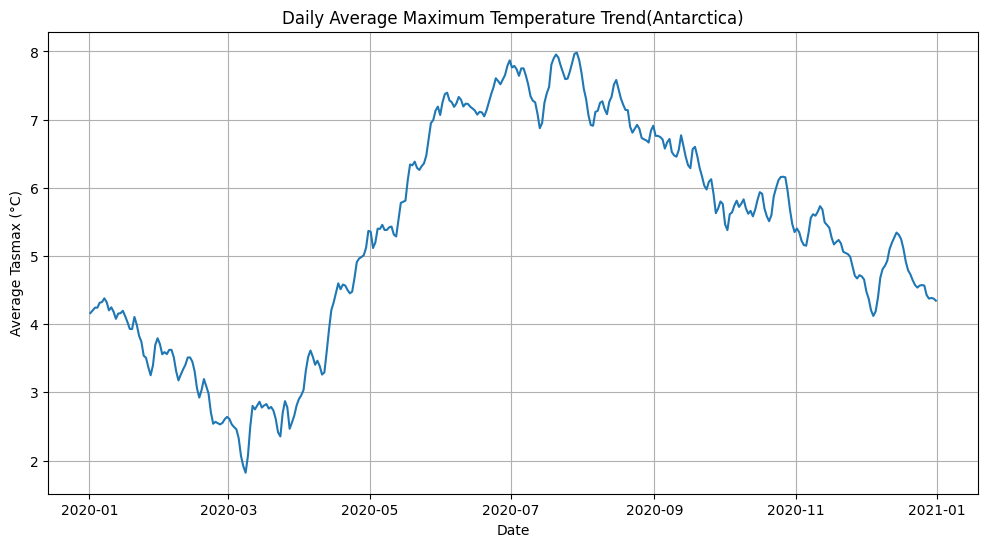

In [0]:
from pyspark.sql.functions import avg, count, when, col

df = spark.read.parquet("/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_cleaned_parquet")
# (Optional) explicitly filter Antarctica to be safe
df_ant = df.filter(col("continent") == "Antarctica")

# Average temperature per day across all grid points
daily_avg = (
    df
    .groupBy("time")
    .agg(avg("tasmax_c").alias("avg_tasmax_c"))
    .orderBy("time")
)

# Convert small aggregated result to Pandas for plotting
daily_avg_pd = daily_avg.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(
    daily_avg_pd["time"],
    daily_avg_pd["avg_tasmax_c"]
)

plt.title("Daily Average Maximum Temperature Trend(Antarctica)")
plt.xlabel("Date")
plt.ylabel("Average Tasmax (°C)")
plt.grid(True)
plt.show()

In [0]:
# Enhancement: Calculate and display the hottest and coldest day (by average tasmax_c) for each continent

from pyspark.sql.window import Window
from pyspark.sql.functions import avg, row_number

df = spark.read.parquet("/FileStore/shared_uploads/rsinha1@saintpetersuniversity1.onmicrosoft.com/ds610/NASA_DATA/tasmax_cleaned_parquet")

# Compute daily average tasmax_c per continent
daily_avg_continent = (
    df.groupBy("continent", "time")
      .agg(avg("tasmax_c").alias("avg_tasmax_c"))
)

# Window for hottest/coldest day per continent
w_desc = Window.partitionBy("continent").orderBy(daily_avg_continent["avg_tasmax_c"].desc())
w_asc = Window.partitionBy("continent").orderBy(daily_avg_continent["avg_tasmax_c"].asc())

# Hottest day per continent
hottest = daily_avg_continent.withColumn("rn", row_number().over(w_desc)).filter("rn = 1").drop("rn")

# Coldest day per continent
coldest = daily_avg_continent.withColumn("rn", row_number().over(w_asc)).filter("rn = 1").drop("rn")

# Display results
print("Hottest day per continent:")
display(hottest)

print("Coldest day per continent:")
display(coldest)

Hottest day per continent:


continent,time,avg_tasmax_c
Africa,2020-12-01T12:00:00.000+0000,25.427990184801104
Antarctica,2020-12-14T12:00:00.000+0000,2.229966796106873
Asia,2020-08-04T12:00:00.000+0000,27.15519277218225
Europe,2020-07-12T12:00:00.000+0000,31.205581168648475
Oceania,2020-01-10T12:00:00.000+0000,21.517860556322685
Unknown,2020-07-26T12:00:00.000+0000,10.423763436889185


Coldest day per continent:


continent,time,avg_tasmax_c
Africa,2020-07-02T12:00:00.000+0000,19.996439647083893
Antarctica,2020-07-13T12:00:00.000+0000,-32.81444989973988
Asia,2020-01-27T12:00:00.000+0000,9.278597097271856
Europe,2020-01-16T12:00:00.000+0000,14.746937253939818
Oceania,2020-07-14T12:00:00.000+0000,13.83041463102772
Unknown,2020-01-28T12:00:00.000+0000,-1.0366679431190897


# References


## # NASA NEX-GDDP climate projections
https://ds.nccs.nasa.gov/thredds/catalog/bypass/NEX-
GDDP/bcsd/catalog.html

https://www.kaggle.com/code/brsdincer/netcdf-information-and-analysis-climate-change
